# Deep Learning: Classifying Astronomical Images

- https://www.astroml.org/astroML-notebooks/chapter9/astroml_chapter9_Deep_Learning_Classifying_Astronomical_Images.html

In [1]:
# to reduce the deprecation warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
#check we have a GPU available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-03-24 10:20:29.692046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1348221724836476347
 xla_global_id: -1]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
%matplotlib inline


Loading some visualization and helper functions
These functions normalize_image, plot_image_array, plot_confusion_matrix, plot_model_history will be used to visualize the data and the outputs of the neural networks as a function of the type and complexity of the network

In [4]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)
    
    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)
    
    return image
    
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=False, 
                     class_true=None, classes=None):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' % 
              (np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx,1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')            
    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

# Load the training samples and create test and validation data sets

The data we are using is taken from a survey for NEOs by Lori Allen and collaborators using DECam on the Blanco 4m Telescope at CTIO. The data comprise a stack of images taken over a period of 5 nights. Within these images we search for slowly moving sources (TNOs) along potential orbital trajectories. Given these trajectories we coadd the images. Our goal is to determine whether there is a point source within the coadded images. The training sample includes images of simulated TNOs (true positives; stamps_sources.npz) and random trajectories where there is no known source (false positives; stamps_noise.npz). The true positives range in signal-to-noise from 100 to 3

In [5]:
# Brute force direct downloads source and noise images to circumvent size limitations 
# for google drive internal virus scan. Download may take some time.

import os
import requests

files = {'sources': (os.path.join('data', 'stamps_noise.npy'), '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ'),
         'noise': (os.path.join('data', 'stamps_sources.npy'), '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc')}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")
        
        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content) 
    print(f"File {name} is downloaded")
            
sources = np.load(files['sources'][0])
noise = np.load(files['noise'][0])

File data/stamps_noise.npy is downloaded
File data/stamps_sources.npy is downloaded


In [6]:
# normalizing images

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))



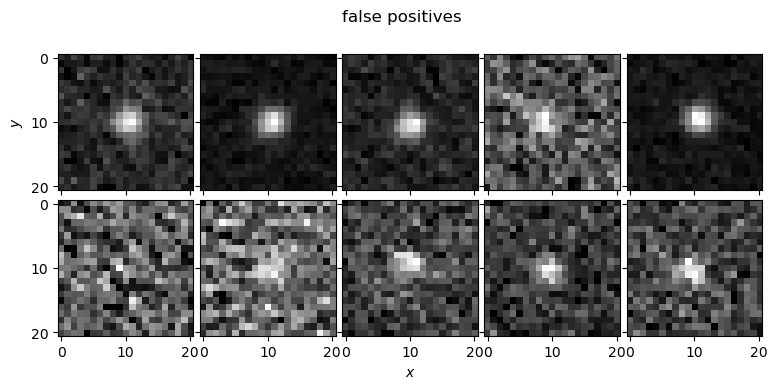

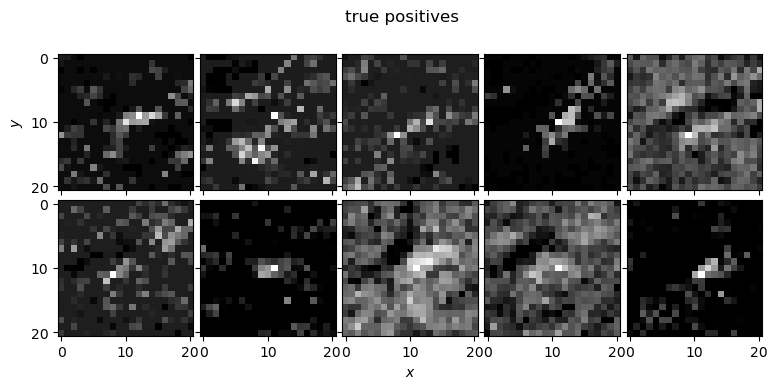

In [7]:
# plot sample of images
plot_image_array(no_point_source_stamps, title='false positives')
plot_image_array(point_source_stamps, title='true positives')


# Create a training, validation, and test sample
We will use astroML’s split_samples to do this split_samples(input_stamps, stamp_class, [0.7,0.1,0.2]) breaks the data in to random selections with appropriate fractions of sources

In [8]:
from tensorflow.keras.utils import to_categorical
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1) 
    labels = to_categorical(labels)
    return data,labels

# combine the false positives and true positives
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 for noise, 1 for a star

# split the samples into training, validation and test data sets
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class, 
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0], 
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (76666); test (21905); and validation (10952) data sets


# Neural Network Frameworks

The development and release of open source deep learning libraries has made the use of deep neural networks accessible to a wide range of fields. Currently there are two common packages PyTorch (https://pytorch.org) and Tensorflow (https://www.tensorflow.org). Either code base can be utilized for the figures and problems in this book (and generally they have the same functionality).
TensorFlow:

# Tensorflow 
is the more established code base with a large community and a large number of tutorials (https://www.tensorflow.org/tutorials) and online courses. Its functionality is more developed than PyTorch with tools to visualize and inspect a network (e.g., see TensorBoard). On the other hand, the learning curve for PyTorch is generally considered to be easier than that for Tensorflow with PyTorch having a more natural object oriented interface for people used to writing Python code.

# PyTorch:
The primary difference between TensorFlow and PyTorch is that the networks (or graphs) that TensorFlow generates are static while the networks for PyTorch are dynamic (see TensorFlow Fold for dynamic graphs). This means that with PyTorch one can modify and adjust the network on-the-fly (e.g., making it easier to adjust for changes in the input dimensionality or number of input nodes within a network). This feature and the object-oriented design of PyTorch often results in fewer lines of code to achieve the same solution when compared to Tensorflow.
Keras:

# Keras 
is a high-level API written on top of TensorFlow (and its precursor Theano). It is written in Python and provides a simple and intuitive interface when building neural networks. It is currently released as part of TensorFlow.

What should you choose? Both frameworks are continuously evolving. The choice of deep learning library will likely come down to which one you find better fits your style of programming and learning. For this tutorial we will use Keras as it has an intuitive implementation of the graphical or network models.
Building a network:

Let’s start by defining what we need for the network. We will start with Keras and

    - create a sequential model (this means we add layers one-by-one as we see in our introductory figure)

    - add a dense (fully connected) layer with 30 neurons

        input_shape describes the dimensionality of the input data to this first hidden layer

        activation describes the activation fuction for the neurons (in this case we will be using ‘relu’; rectified linear unit)

    - add a second dense (fully connected) layer with 30 neurons

    - flatten the output of the second layer into a single vector so we can use categorical_crossentropy as we are assuming that our classes are “one-hot encoding” (i.e. [1,0] or [0,1]

    - add an output layer using “softmax” (this means the activation values for each class sum to 1 so they can be treated like probabilities) with 2 nodes (for our example we could have used a single output)

# Training the network
Training a neural network is conceptually simple. Given a labelled set of data and a loss function, we need to optimize the weights and biases within the network by minimizing the loss. A solution for training large networks uses backpropagation to efficiently estimate the gradient of the loss function with respect to the weights and biases.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical

def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
        
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [10]:
#output the structure of the model
simple_model = simple()
simple_model.summary()


Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 21, 21, 30)        60        
                                                                 
 fc_2 (Dense)                (None, 21, 21, 30)        930       
                                                                 
 flatten (Flatten)           (None, 13230)             0         
                                                                 
 fc_out (Dense)              (None, 2)                 26462     
                                                                 
Total params: 27,452
Trainable params: 27,452
Non-trainable params: 0
_________________________________________________________________


In [11]:
n_epochs=1
batch_size=1
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)

76666/76666 [==============================] - 68s 864us/step - loss: 0.5664 - accuracy: 0.6858 - val_loss: 0.3550 - val_accuracy: 0.8966


# Excercise
Mini-batch: Optimization of the weights uses a standard gradient descent technique. If the loss function can be expressed in terms of a sum over subsets of the training data (e.g., as is the case for the L2 norm) the training can be undertaken either for the dataset as a whole, for subsets of the data (batch learning), or for individual entries (on-line or stochastic learning). Batch gradient descent looks at all points in the data and calculates the average gradients before updating the weights in the model. Stochastic gradient descent takes a single point and calculates the gradients and then updates the model (and then repeats). Mini-batch gradient descent takes a subset of the training data and calculates the average gradients and updates the model (and then repeats over all mini-batches).

In [13]:
n_epochs=20
batch_size= 64
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)


Epoch 1/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2886 - accuracy: 0.9036 - val_loss: 0.2868 - val_accuracy: 0.9023
Epoch 2/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2842 - accuracy: 0.9044 - val_loss: 0.2831 - val_accuracy: 0.8999
Epoch 3/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2807 - accuracy: 0.9047 - val_loss: 0.2798 - val_accuracy: 0.9032
Epoch 4/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2776 - accuracy: 0.9060 - val_loss: 0.2776 - val_accuracy: 0.8986
Epoch 5/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2750 - accuracy: 0.9067 - val_loss: 0.2751 - val_accuracy: 0.9015
Epoch 6/20
1198/1198 [==============================] - 11s 9ms/step - loss: 0.2727 - accuracy: 0.9067 - val_loss: 0.2729 - val_accuracy: 0.9052
Epoch 7/20
1198/1198 [==============================] - 12s 10ms/step - loss: 0.2707 - accuracy: 0.9081 - val_loss: 0.2714 - val_a

In [23]:
# use the network to predict class values
classes = simple_model.predict(data_test)
print (classes)


685/685 [==============================] - 6s 8ms/step
[[0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 ...
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]]


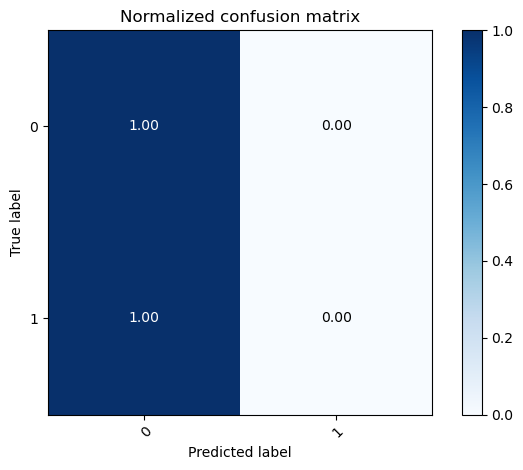

In [24]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')



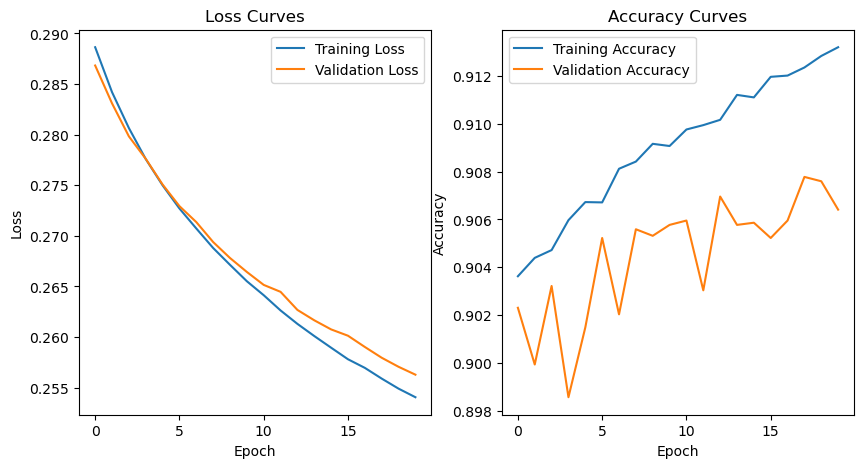

In [16]:
# plot the training history of the network
plot_model_history(simple_model_history)

# Batch normalization

Our first optimization over the vanila NN. Batch normalization scales the activations from a layer (note we normalized the input data) to have zero mean and unit variance. In reality, the two parameters gamma (for the standard deviation) and beta (for the mean) are learned by the network and the activations multiplied/added by these parameters. Batch normalization provides a degree of regularization and allows for faster learning rates as the outputs are constrained to 0-1 (i.e. you dont get large excursions in the weights of subsequent layers in a network that need to be reoptimized/trained).

The normalization is applied to mini-batches of training data (as opposed to using the full training sample)

    add a batch normalization layer: model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))


In [17]:
def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
        
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model



In [18]:
n_epochs=20
simple_model = simpleBN()
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Epoch 1/20
300/300 [==============================] - 9s 28ms/step - loss: 0.6890 - accuracy: 0.5481 - val_loss: 0.6884 - val_accuracy: 0.5482
Epoch 2/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6883 - accuracy: 0.5482 - val_loss: 0.6883 - val_accuracy: 0.5482
Epoch 3/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6883 - accuracy: 0.5482 - val_loss: 0.6882 - val_accuracy: 0.5482
Epoch 4/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6882 - accuracy: 0.5482 - val_loss: 0.6882 - val_accuracy: 0.5482
Epoch 5/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6881 - accuracy: 0.5482 - val_loss: 0.6880 - val_accuracy: 0.5482
Epoch 6/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6880 - accuracy: 0.5482 - val_loss: 0.6880 - val_accuracy: 0.5482
Epoch 7/20
300/300 [==============================] - 8s 27ms/step - loss: 0.6880 - accuracy: 0.5482 - val_loss: 0.6879 - val_accuracy: 0.5482

# Plot normalized confusion matrix


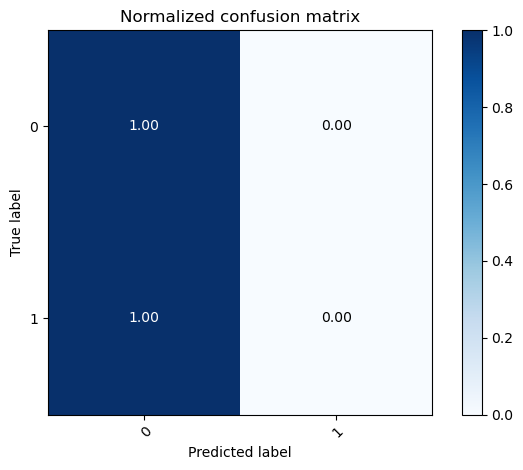

In [19]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')


# Convolutional Networks

Convolutional Neural Networks or CNNs are networks designed to work with images or with any regularly sampled dataset. CNNs reduce the complexity of the network by requiring that neurons only respond to inputs from a subset of an image (the receptive field). This mimics the operation of the visual cortex where neurons only respond to a small part of the field-of-view.

There are four principal components to a CNN:

    a convolutional layer,

    a non-linear activation function ,

    a pooling or downsampling operation, and

    a fully connected layer for classification

Dependent on the complexity of the network or structure of the data, these components can occur singularly or chained together in multiple sequences.

- The kernel only responds to pixels within its receptive field (i.e., the size of the kernel), reducing the computational complexity of the resulting network. The kernels in the convolution are described by a depth (the number of kernels, , applied to the image), and a stride (how many pixels a kernel shifts at each step in the convolution; typically one). Given an image, the result of the convolution step is to transform a single image into a data cube of feature maps with a dimension

.

- Once learned the kernels within the convolutional layer can appear as physically intuitive operations on the images such as edge detection filters.

- As with traditional neural networks, a non-linear activation function is applied to the individual pixels in the resulting feature maps.

- The pooling in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region of interest (e.g., a 2x2 pixel window). The summary can be the average pixel value but more commonly the maximum pixel value is preserved (Max Pooling) in the downsampling. This pooling of the feature maps reduces the size of the resulting network and makes the network less sensitive to small translations or distortions between images.

- The final layer of a CNN is the classification layer which maps the output of the CNN to a set of labels. This is typically a fully connected layer where each output of the final pooling layer connects to all neurons in the classification layer.

# CNNs: Increasing the complexity of the architecture with VGG6
Let’s start with a simple network architecture from Oxford’s Visual Geometry Group. VGG6 is a very simple network that performs well in traditional image classification competitions (e.g. those using the ImageNet data)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

# The use of dropout layers
As we increase the complexity of the network we run into the issue of overfitting the data (as seen in many of the astroML examples). The dropout layer model.add(tf.keras.layers.Dropout(0.5)) at each training epoch randomly sets a neuron to 0 with a probability of 0.5. There is debate over whether the dropout layer should come before or after an activation layer but a recommended rule of thumb is that it should come after the activation layer for activation functions other than relu.

In [21]:
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=15
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=2, 
                                  validation_data=(data_val, class_val), shuffle=True)
classes = vgg_model.predict(data_test)


Model: "VGG6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 19, 19, 16)        160       
                                                                 
 conv2 (Conv2D)              (None, 17, 17, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 32)          4640      
                                                                 
 conv4 (Conv2D)              (None, 4, 4, 32)          9248      
                                                              

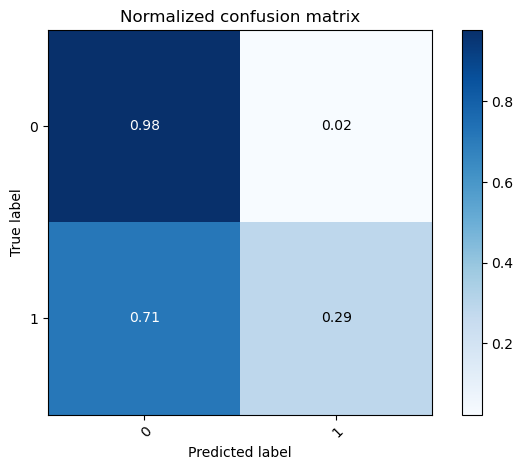

In [22]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')


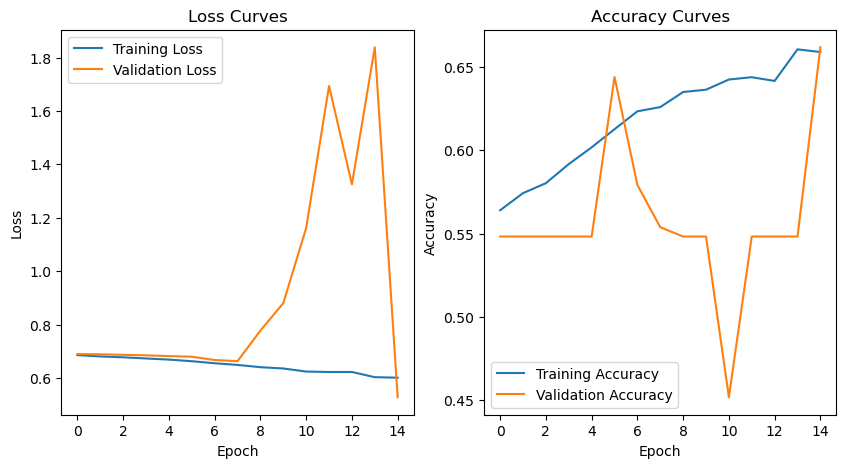

In [25]:
# plot the training history
plot_model_history(vgg_model_history)

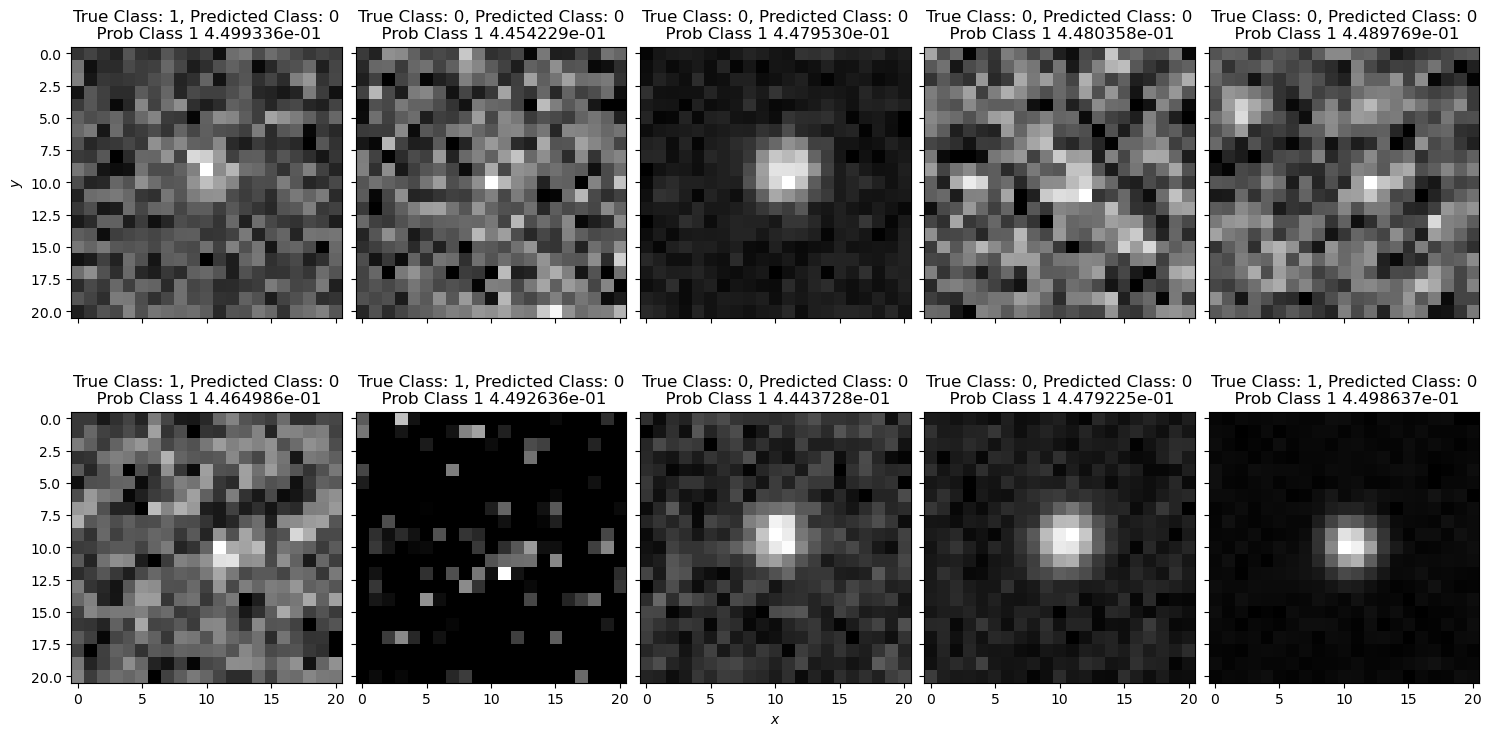

In [26]:
# plot example classifications
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)


# Interpreting networks: how many layers and how many neurons?

The number of layers, number of neurons in a layer, and the connectivity of these layers is typically described as the network architecture.

Approaches to defining a network architecture become more trial and error than applying an underlying set of principles. For a starting point, however, there are relatively few problems that benefit significantly from more than two layers and we recommend starting with a single layer when training an initial network and using cross-validation to determine when additional layers lead result in the data being overfit.

As with the number of layers, the number of neurons within a layer drives the computational cost (and requiring progressively larger training sets to avoid overfitting of the data). There are many proposals for rules of thumb for defining a network architecture:

    the number of neurons should lie between the number of inputs and output nodes

    the number of neurons should be equal to the number of outputs plus 2/3rd the number input nodes.

    the number of neurons in the hidden layer should be less than twice the size of the input layers


# Interpreting networks: where is a network looking
Occulsion maps, saliency maps, class activation maps are all techniques for expressing which pixels contribute to classification. These are attempts to reduce the “black box” nature of the networks. The simplest of these is the occlussion map where we part of an image and calculate the probability of it belonging to a class. If the probability decreases the occluded part of the image is assumed to be important. If there is no change in probability the occluded pixels are not assumed to be important. A simple implementation of this is shown here.

10/10 [==============================] - 0s 6ms/step


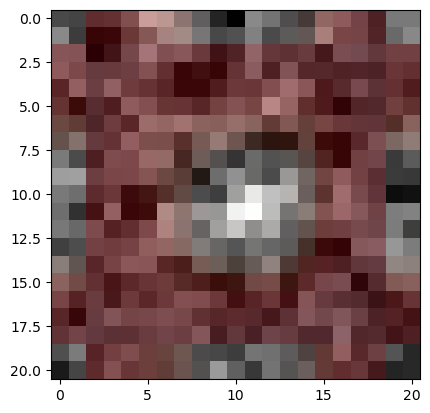

In [27]:
model = vgg_model
image_number = 11

kernel_size=5
input_stamp = data_test[image_number].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = 1. - model.predict(keras_stamps)
heatmap = probs[:,1].reshape(22-kernel_size,22-kernel_size)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=np.int(kernel_size/2), mode='minimum')

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(data_test[image_number].reshape(21,21), cmap='gray')
ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap)



# Exercise for the reader: more complicated architectures: resnet50

In [28]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [29]:
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                          validation_data=(data_val, class_val), shuffle=True)


Epoch 1/5
300/300 [==============================] - 1638s 5s/step - loss: 0.1330 - accuracy: 0.9623 - val_loss: 1.7131 - val_accuracy: 0.4518
Epoch 2/5
300/300 [==============================] - 1625s 5s/step - loss: 0.0348 - accuracy: 0.9874 - val_loss: 0.4530 - val_accuracy: 0.7978
Epoch 3/5
300/300 [==============================] - 1608s 5s/step - loss: 0.0281 - accuracy: 0.9894 - val_loss: 0.2295 - val_accuracy: 0.9259
Epoch 4/5
300/300 [==============================] - 1749s 6s/step - loss: 0.0227 - accuracy: 0.9919 - val_loss: 0.0475 - val_accuracy: 0.9834
Epoch 5/5
300/300 [==============================] - 1862s 6s/step - loss: 0.0174 - accuracy: 0.9935 - val_loss: 0.6879 - val_accuracy: 0.8835


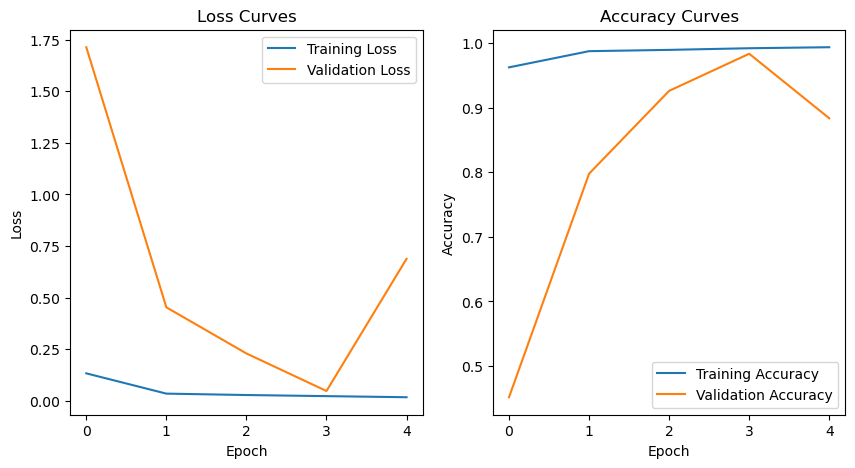

In [30]:
# plot the training history
plot_model_history(resnet_model_history)

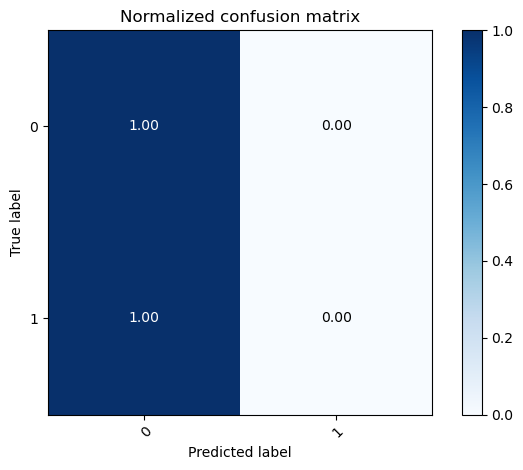

In [31]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')